In [1]:
import wget
import pandas as pd
import numpy as np
import seaborn as sns
from astropy.io import fits
import matplotlib.pyplot as plt
import ray
import tensorflow as tf

In [2]:
def descarga_wget(database,ID,path_3,path_4):
    _,field,types,_ = ID.lower().split("-")
    try :
        if types=="ell":
            types="ecl"
        if database==4:
            if ((field =="blg") |(field =="gd"))&((types =="ecl")|(types =="lpv")|(types =="dsct")):
                url = "http://ftp.astrouw.edu.pl/ogle/ogle4/OCVS/"+field+"/"+types+"/phot_ogle4/I/"+ ID +".dat"
                wget.download(url,path_4)
                return 1
            else:
                url = "http://ftp.astrouw.edu.pl/ogle/ogle4/OCVS/"+field+"/"+types+"/phot/I/"+ ID +".dat"
                wget.download(url,path_4)
                return 1
                
        if database==3:
            url = "http://ftp.astrouw.edu.pl/ogle/ogle3/OIII-CVS/" +field+"/"+types+"/phot/I/"+ ID +".dat"
            wget.download(url,path_3)
            return 1
    except:
        return 0

In [3]:
def make_2d_histogram(n_bins_x,n_bins_y,data_mag,data_fase,norm_max):
    bins_x = np.linspace(0,1, n_bins_x) # Curves in phase between 0 and 2.
    bins_y = np.linspace( data_mag.min(), data_mag.max(), n_bins_y)
    hist_data, _xbins, _ybins = np.histogram2d(data_fase, data_mag, bins=(bins_x, bins_y))
    # Data in histogram is transposed, then transpose it just once:
    if norm_max=="max":
        norm_max = hist_data.max()
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu
    else:
        norm_max = float(norm_max)
        hist_data[hist_data > norm_max ] = norm_max
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu

In [4]:
def create_hdf5(lc_sigma,posible_periods):
    results_ids = []
    for per in posible_periods:
        hdu = process_period.remote(per, lc_sigma)
        results_ids.append((hdu))
        
    x = np.empty((len(posible_periods), 32, 32))
    for i,key in enumerate(results_ids):
        ima = ray.get(key)
        x[i] = ima
    x = np.expand_dims(x, axis=3)
    return x

In [5]:
def make_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape=(32, 32, 1),activation="relu",padding="same"),
    tf.keras.layers.Conv2D(16, (3,3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3),activation="relu",padding="same"),
    tf.keras.layers.Conv2D(32, (3, 3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.3),
   # tf.keras.layers.Dense(1, activation='sigmoid')
    tf.keras.layers.Dense(8, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=0.1), loss="sparse_categorical_crossentropy", metrics=['acc'])
    return model

In [6]:
model_softmax = make_model()
model_softmax.load_weights("entrenamientos/entrenamiento_8_sep/training_softmax_batchBalanced_prueba_69721mil/cp.ckpt")


2023-11-24 17:35:07.045045: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-24 17:35:07.045188: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 17:35:07.047212: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
ray.init()

2023-11-24 17:35:12,023	INFO worker.py:1621 -- Started a local Ray instance.


Python version:,3.8.18
Ray version:,2.6.1


In [8]:
@ray.remote
def process_period(per, lc_sigma, size_x=32, size_y=32, norm_max=7):
    lc_sigma["fase"] = np.mod(lc_sigma.HJD, per) / per
    hdu = make_2d_histogram(size_x+1, size_y+1, lc_sigma.mag, lc_sigma.fase, norm_max=norm_max)
    return hdu.data

In [206]:
descarga_wget(3,"OGLE-GD-ECL-00692","UseCNN/Lc_Data/test_1_lc/",".")

100% [..............................................................................] 46104 / 46104

1

In [207]:
lc = pd.read_csv("UseCNN/Lc_Data/test_1_lc/OGLE-GD-ECL-00692.dat",names=["HJD","mag","err"],delim_whitespace=True)

In [208]:
lc_sigma = lc.loc[(lc["mag"] < np.mean(lc["mag"]) + 3*np.std(lc["mag"])) & ( lc["mag"] > np.mean(lc["mag"]) - 3*np.std(lc["mag"]) )].reset_index(drop=True)


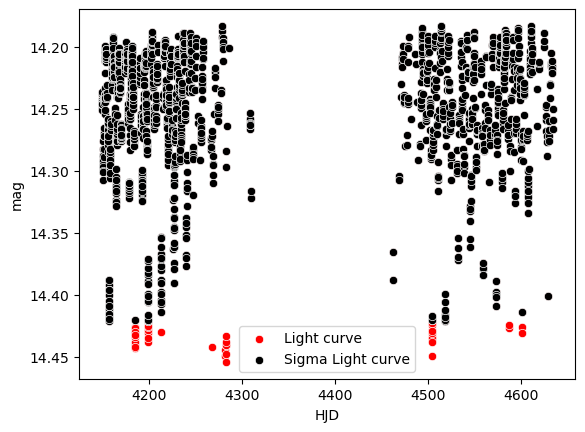

In [209]:
sns.scatterplot(data=lc,x="HJD",y="mag",color="red",label="Light curve")
sns.scatterplot(data=lc_sigma,x="HJD",y="mag",color="black",label="Sigma Light curve")
plt.gca().invert_yaxis()

In [221]:
#posible_periods = np.linspace(0.1,0.5,10000)
posible_periods = np.logspace(-1, 2, num=1000, base=10)


In [222]:
%%time
data = create_hdf5(lc_sigma,posible_periods)


CPU times: user 611 ms, sys: 65.5 ms, total: 676 ms
Wall time: 552 ms


In [223]:
df  = pd.DataFrame(model_softmax.predict(data),columns=['ELL', 'Mira', 'cep', 'dsct', 'ecl', 'lpv', 'rrlyr',"Random"])
df["max_predict"] = df.max(axis=1)
df["Name_predict"] = df.idxmax(axis=1)
df["per"] = posible_periods

In [224]:
import plotly.graph_objects as go

# Supongamos que tienes un DataFrame 'df' con las columnas 'per', 'Random', y 'color'

# Crear la figura
fig = go.Figure()

text = [f"{x_val},{mp}, {np}" for x_val, mp, np in zip(df['per'],df['max_predict'], df['Name_predict'])]

# Añadir la línea
fig.add_trace(go.Scatter(
    x=df['per'],
    y=df['Random'],
    mode='lines',  # 'lines', 'markers', o 'lines+markers'
    name='Random',
    hoverinfo='text',  # Muestra solo el texto personalizado
    text=text,  # Texto personalizado para cada punto
    line=dict(color='black')  # Texto personalizado para cada punto
))
# Invertir el eje y
fig.update_yaxes(autorange="reversed")


# Actualizar el layout si es necesario
fig.update_layout(
    title="Línea con Anotaciones",
    xaxis_title="per",
    yaxis_title="Random",
    template="simple_white"
)

# Mostrar la figura
fig.show()

In [225]:
df.loc[(df["Name_predict"]!="Random")&((df["Name_predict"]!="lpv"))&((df["Name_predict"]!="Mira"))].sort_values(by="max_predict")

,ELL,Mira,cep,dsct,ecl,lpv,rrlyr,Random,max_predict,Name_predict,per
654,0.002148,1.295868e-04,7.160592e-09,2.535965e-06,0.542169,9.808676e-02,6.764258e-09,3.574642e-01,0.542169,ecl,9.203732
715,0.009166,4.829083e-04,2.103551e-08,1.437438e-06,0.603950,2.287837e-02,2.430258e-09,3.635206e-01,0.603950,ecl,14.032891
455,0.016364,1.947240e-03,3.101448e-06,3.128883e-05,0.755590,3.201128e-02,9.515552e-08,1.940531e-01,0.755590,ecl,2.324697
712,0.067947,1.615478e-03,1.847437e-07,5.651752e-06,0.793867,4.709385e-02,2.476975e-08,8.947162e-02,0.793867,ecl,13.744791
716,0.000546,3.864337e-05,2.471770e-09,5.783251e-08,0.992094,1.782956e-03,1.128744e-09,5.538289e-03,0.992094,ecl,14.130260
710,0.001167,5.669790e-06,4.772704e-11,8.175656e-11,0.997376,7.529306e-05,4.272438e-13,1.375814e-03,0.997376,ecl,13.556018
713,0.000039,2.926575e-10,1.886148e-09,5.591350e-15,0.999961,7.958441e-11,7.456524e-15,2.222571e-08,0.999961,ecl,13.840161


In [226]:
predict_per = df.loc[(df["Name_predict"]!="Random")&
                     (df["Name_predict"]!="lpv")&((df["Name_predict"]!="Mira"))].sort_values(by="max_predict",ascending=False)["per"].values[0]

In [227]:
lc_sigma["fase_predict_Per"] = np.mod(lc_sigma.HJD, predict_per) / predict_per

In [228]:
real_per =  13.82170000
lc_sigma["fase_real_Per"] = np.mod(lc_sigma.HJD, real_per) / real_per

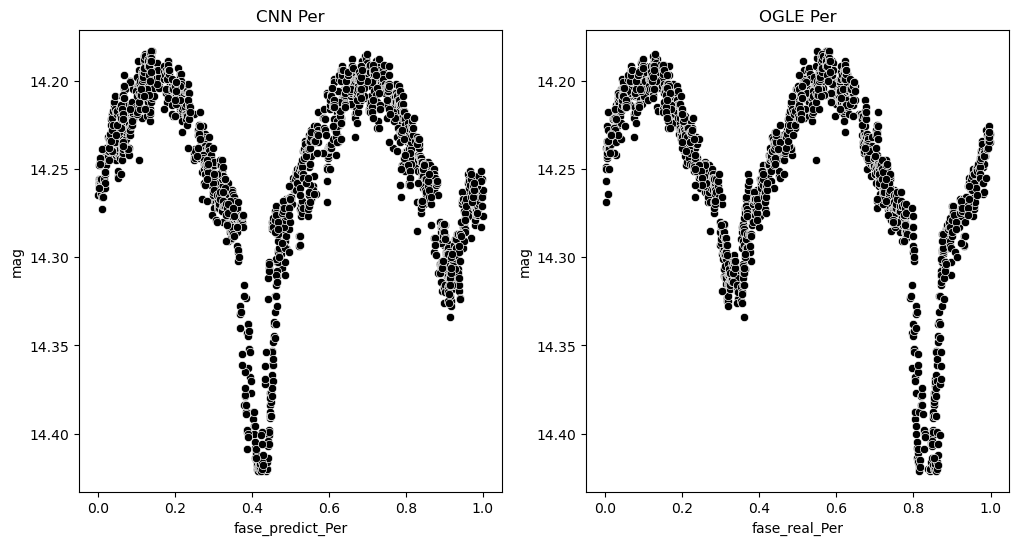

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que tienes un DataFrame 'lc_sigma' con las columnas 'fase_predict_Per', 'fase_real_Per', y 'mag'

# Crear una figura y un arreglo de ejes (subplots) con Matplotlib
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Primer gráfico de dispersión en el primer subplot
sns.scatterplot(data=lc_sigma, x="fase_predict_Per", y="mag", ax=axs[0], color="black")
axs[0].set_title("CNN Per")

axs[0].invert_yaxis()
# Segundo gráfico de dispersión en el segundo subplot
sns.scatterplot(data=lc_sigma, x="fase_real_Per", y="mag", ax=axs[1], color="black")
axs[1].set_title("OGLE Per")
axs[1].invert_yaxis()
# Mostrar la figura

